In [15]:
pip install nltk


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [17]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Preprocessing

In [18]:
def parse_data_line(data_line):
    label = data_line[1].strip()
    text = data_line[2].strip()
    return (label, text)

In [19]:
data_line = ["410734138242126311", "positive", "I believe this is great for me!"]

label, text = parse_data_line(data_line)

def pre_process(text):
    tokens = text.lower().split()
    # This method transforms the text to lowercase and splits each word into tokens which can be seen printed below. 
    return tokens  # Changed [tokens] to tokens

tokens = pre_process(text)
print("label:", label)
print("tokens:", tokens)


label: positive
tokens: ['i', 'believe', 'this', 'is', 'great', 'for', 'me!']


# Feature Extraction

In [20]:
global_feature_dict = {} # Global dictionary of words encountered from all processed text

# The goal of the below fucntion is 

def to_feature_vector(tokens):
    featureVector = {} # Local feature dictionary that stores a set of tokens
    for t in tokens:
        featureVector[t] = 1 # If the token is present give a value of 1 (Binary occurrence) 
#Below is adding any new token not currently in the global dictionary to it & giving it a unique index        
        if t not in global_feature_dict:
            global_feature_dict[t] = len(global_feature_dict) + 1

    return featureVector # returning the local feature vector whilst showing which tokens are present in this text.

# Example set of tokens from a preprocessed text
tokens = ["I","believe","this","is","great","for","me"]

# Generating the feature vector
featureVector = to_feature_vector(tokens) 

# Printing the feature vector to inspect the output
print("Feature vector:", featureVector)  

# Printing the global feature dictionary to see the unique ids for each token
print("Global feature dictionary:", global_feature_dict)


Feature vector: {'I': 1, 'believe': 1, 'this': 1, 'is': 1, 'great': 1, 'for': 1, 'me': 1}
Global feature dictionary: {'I': 1, 'believe': 2, 'this': 3, 'is': 4, 'great': 5, 'for': 6, 'me': 7}


In [21]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Cross-validation

In [22]:
#solution

# From the sklearn library we are using the functions imported below to retrieve the metrics, precision, recall, f1 score & accuracy 
from sklearn.metrics import classification_report, precision_score, f1_score, recall_score, accuracy_score

# The Cross_validate function performs a k-folds-cross-validation on the data and calculates the metrics for each fold
def cross_validate(dataset, folds=10):

# The dictionary named cv_results stores the cumulative results for each metric across all folds, eventually intending to hold the average for each metric      
    cv_results = {
        "precision": 0,
        "recall": 0,
        "f1_score": 0,
        "accuracy": 0    
    }

# fold_ size dictates the number of samples per fold, with the + 1 ensuring every fold has at least one sample
    fold_size = int(len(dataset) / folds) + 1

# The for loop looks to iterate through the dataset in increments of fold size, i marks the start of each fold    
    for i in range(0, len(dataset), fold_size):
# Validation_data, consists of the samples in the current fold
# Training_data, consists of the combination of all other samples outside the current fold
        validation_data = dataset[i:i + fold_size]
        training_data = dataset[:i] + dataset[i + fold_size:]
        
# Training the classifier on the training data, using the function train_classifier
        classifier = train_classifier(training_data)
        
# Preparing the validation data
        validation_samples = [sample[0] for sample in validation_data] # Extracts feature vector from validation data
        validation_labels = [sample[1] for sample in validation_data]  # Extracts the labels
# The predict labels function helps  generate predictions on the validation samples using the trained classifier        
        predictions = predict_labels(validation_samples, classifier)
        
# Calculate metrics for the current fold, precision, recall, f1_score, and accuracy (The average = 'macro' calculates the metric and averages them, while zero_division is used to help prevent errors by setting the metric to zero when there are no predicted samples)
        fold_precision = precision_score(validation_labels, predictions, average='macro', zero_division=0)
        fold_recall = recall_score(validation_labels, predictions, average='macro', zero_division=0)
        fold_f1score = f1_score(validation_labels, predictions, average='macro', zero_division=0)
        fold_accuracy = accuracy_score(validation_labels, predictions)

# Accumulating the fold results
        cv_results["precision"] += fold_precision
        cv_results["recall"] += fold_recall 
        cv_results["f1_score"] += fold_f1score
        cv_results["accuracy"] += fold_accuracy
        
        print(f"Fold {i // fold_size + 1} - Precision: {fold_precision:.4f}, Recall: {fold_recall:.4f}, F1 Score: {fold_f1score:.4f}, Accuracy: {fold_accuracy:.4f}")
    
# Computing the average for each metric by dividing by the number of folds.
    for metric in cv_results:
        cv_results[metric] /= folds

    return cv_results

In [23]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [24]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
91359


In [25]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...
Fold 1 - Precision: 0.8246, Recall: 0.8146, F1 Score: 0.8192, Accuracy: 0.8491
Training Classifier...
Fold 2 - Precision: 0.7683, Recall: 0.7621, F1 Score: 0.7651, Accuracy: 0.8402
Training Classifier...
Fold 3 - Precision: 0.7827, Recall: 0.7816, F1 Score: 0.7822, Accuracy: 0.7932
Training Classifier...
Fold 4 - Precision: 0.8436, Recall: 0.8421, F1 Score: 0.8422, Accuracy: 0.8424
Training Classifier...
Fold 5 - Precision: 0.8162, Recall: 0.8049, F1 Score: 0.8099, Accuracy: 0.8316
Training Classifier...
Fold 6 - Precision: 0.8404, Recall: 0.8216, F1 Score: 0.8294, Accuracy: 0.8495
Training Classifier...
Fold 7 - Precision: 0.8336, Recall: 0.8196, F1 Score: 0.8258, Accuracy: 0.8480
Training Classifier...
Fold 8 - Precision: 0.8230, Recall: 0.8078, F1 Score: 0.8144, Accuracy: 0.8376
Training Classifier...
Fold 9 - Precision: 0.8306, Recall: 0.8164, F1 Score: 0.8226, Accuracy: 0.8443
Training Classifier...
Fold 10 - Precision: 0.8309, Recall: 0.8188, F1 Score: 0.82

{'precision': np.float64(0.8193813524160024),
 'recall': np.float64(0.8089548756858059),
 'f1_score': np.float64(0.8135072674208077),
 'accuracy': 0.8379190530609335}

# Error Analysis

Training Classifier...


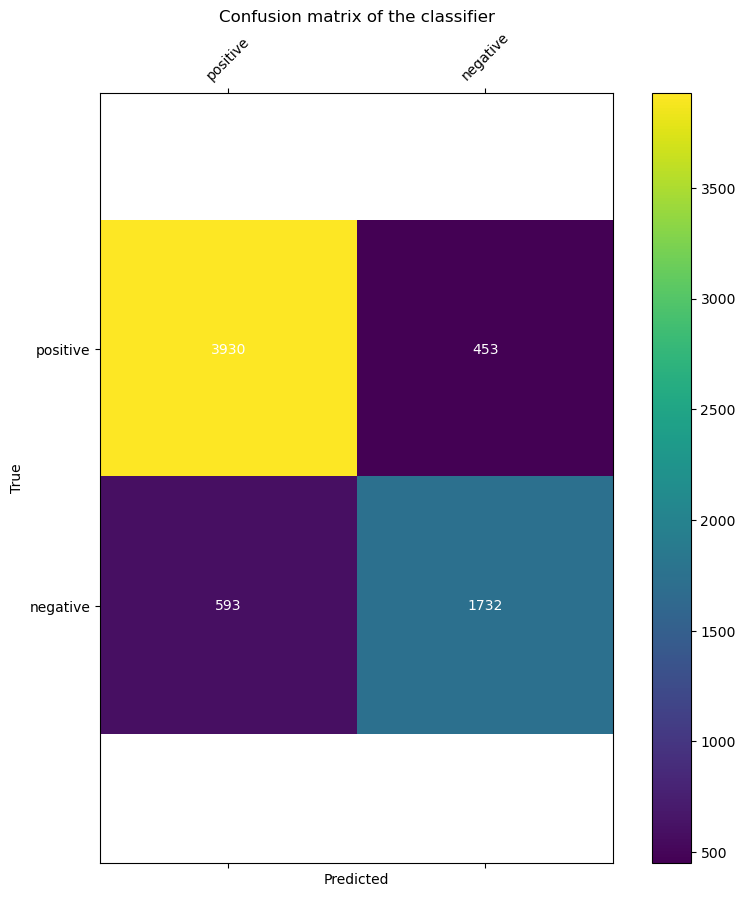

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

# Extract true labels and feature vectors from test data
y_test = [label for _, label in test_data]  # True labels
X_test = [features for features, _ in test_data]  # Feature vectors

# Train classifier and generate predictions
classifier = train_classifier(train_data)  # Train classifier
preds = predict_labels(X_test, classifier)  # Generate predictions

# Plot the confusion matrix
confusion_matrix_heatmap(y_test, preds, labels=["positive", "negative"])

In [27]:
from sklearn.metrics import confusion_matrix

# Prepare test samples and labels
test_samples = [sample[0] for sample in test_data]
test_labels = [sample[1] for sample in test_data]

# Generate predictions
predictions = predict_labels(test_samples, classifier)

# Calculate confusion matrix and display
conf_matrix = confusion_matrix(test_labels, predictions, labels=["positive", "negative"])
print("Confusion Matrix:\n", conf_matrix)

# Find false positives and false negatives
false_positives = [(text, true, pred) for text, true, pred in zip(test_samples, test_labels, predictions)
                   if pred == "positive" and true == "negative"]
false_negatives = [(text, true, pred) for text, true, pred in zip(test_samples, test_labels, predictions)
                   if pred == "negative" and true == "positive"]

# Save errors to file
with open("error_analysis_output.txt", "w") as f:
    f.write("False Positives:\n")
    for fp in false_positives:
        f.write(f"Text: {fp[0]}, Actual: {fp[1]}, Predicted: {fp[2]}\n")
    f.write("\nFalse Negatives:\n")
    for fn in false_negatives:
        f.write(f"Text: {fn[0]}, Actual: {fn[1]}, Predicted: {fn[2]}\n")

print("Error analysis saved to 'error_analysis_output.txt'.")


Confusion Matrix:
 [[3930  453]
 [ 593 1732]]
Error analysis saved to 'error_analysis_output.txt'.


# Optimising pre-processing and feature extraction

In [14]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, "we'll": 1, 'release': 1, 'our': 1, '58th': 1, 'episode': 1, 'of': 1, '#hsonair': 1, 'profiling': 1, 'very': 1, 'own': 1, '@alissadossantos': 1, '!': 1, 'talk': 1, 'about': 1, 'storytelling': 1, 'and': 1, 'beyonce!': 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.842476
Recall: 0.844067
F Score:0.842872
